<a href="https://colab.research.google.com/github/myy04/Real-Fake-Image-Classifier/blob/main/CLIP_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [13]:
import torch
from torch import nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from transformers import AutoModel, AutoProcessor
import os
import torchvision
import torchvision.transforms as transforms
from torch import Tensor

import warnings
warnings.filterwarnings("ignore")

In [14]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("birdy654/cifake-real-and-ai-generated-synthetic-images")

print("Path to dataset files:", path)

Path to dataset files: /root/.cache/kagglehub/datasets/birdy654/cifake-real-and-ai-generated-synthetic-images/versions/3


In [15]:
class ImageDataset(Dataset):
    def __init__(self, path):

        real_images_directory = os.path.join(path, 'REAL')
        fake_images_directory = os.path.join(path, 'FAKE')

        real_images = []
        fake_images = []

        for file in os.listdir(real_images_directory):
            real_images.append(os.path.join(real_images_directory, file))

        for file in os.listdir(fake_images_directory):
            fake_images.append(os.path.join(fake_images_directory, file))

        self.images = []
        for i in range(min(len(real_images), len(fake_images))):
            self.images.append((real_images[i], torch.tensor([1, 0], dtype = torch.float32)))
            self.images.append((fake_images[i], torch.tensor([0, 1], dtype = torch.float32)))


    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image_path = self.images[idx][0]

        return Image.open(image_path).convert("RGB"), self.images[idx][1]



eval_dataset = ImageDataset(os.path.join(path, 'test'))



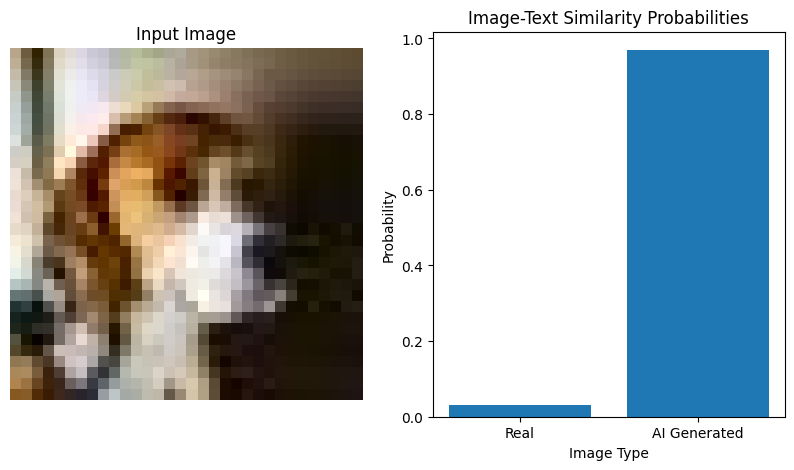

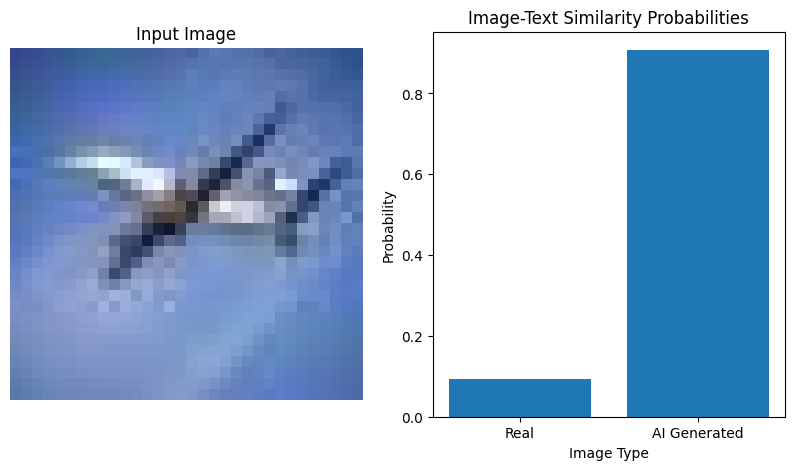

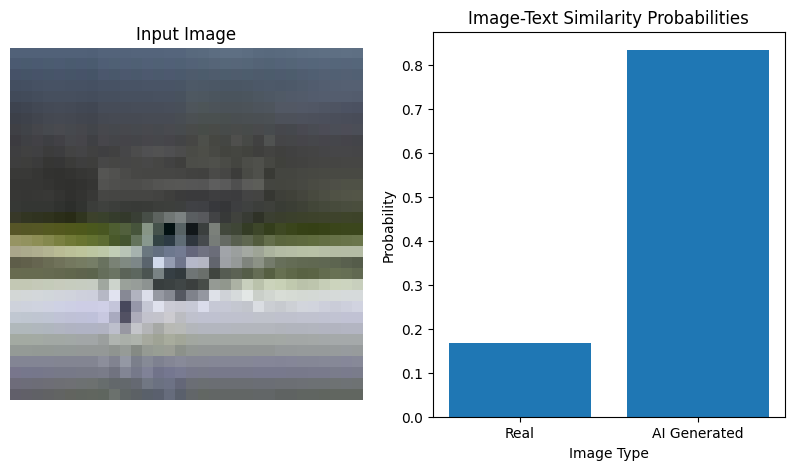

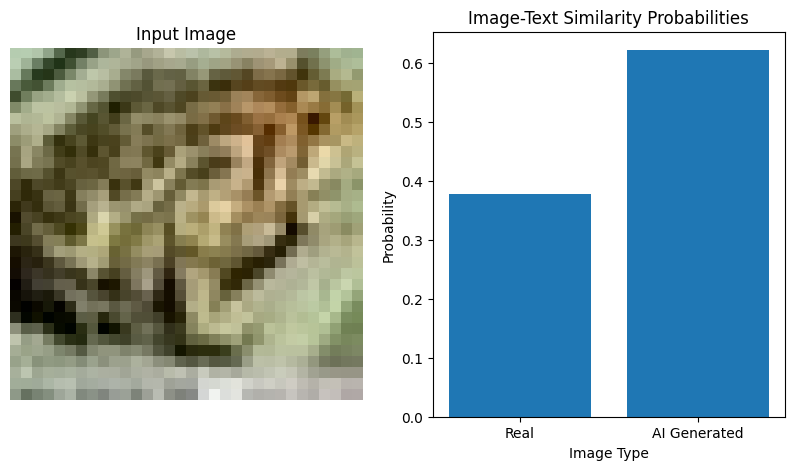

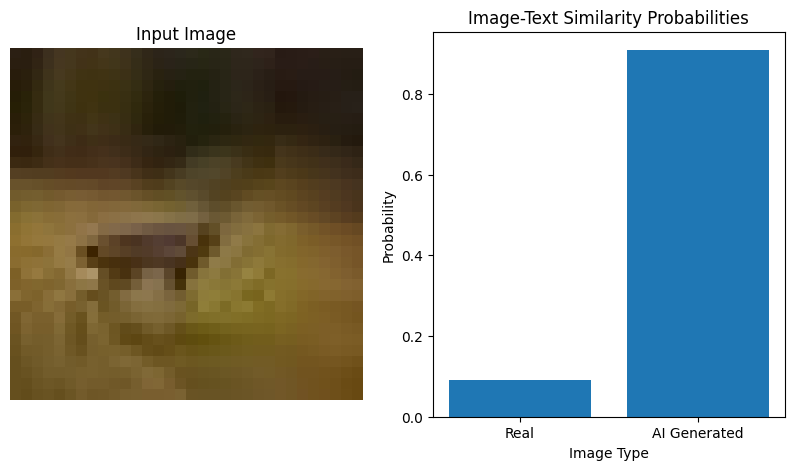

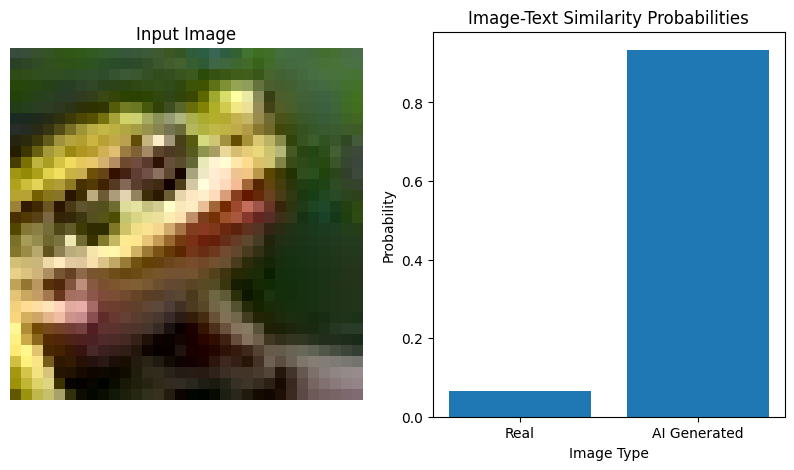

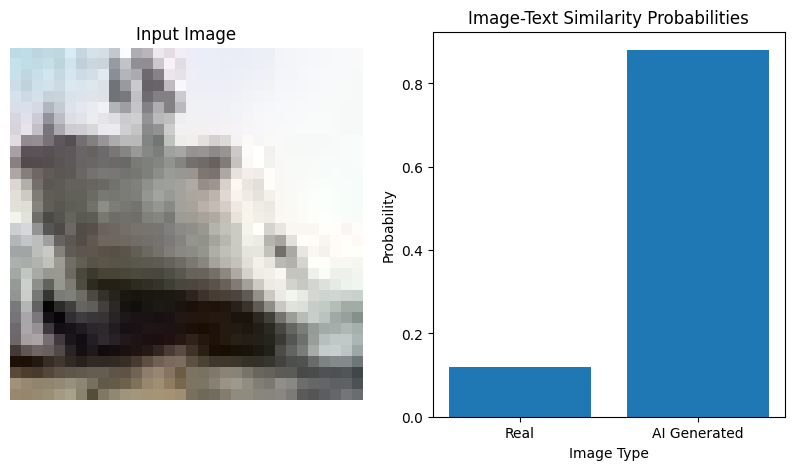

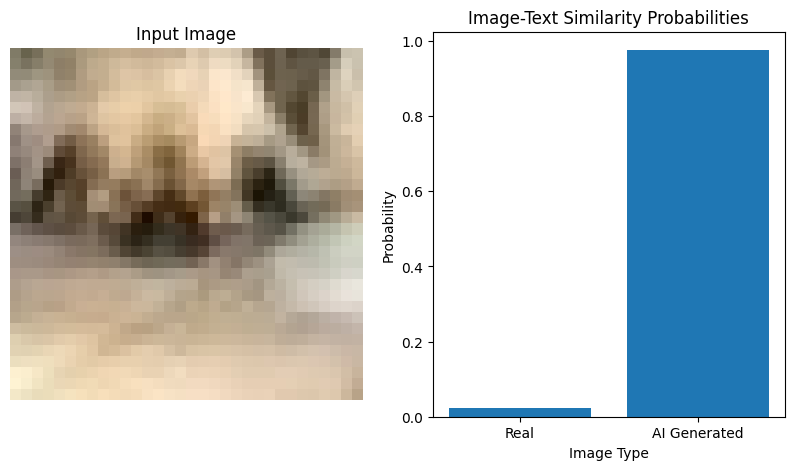

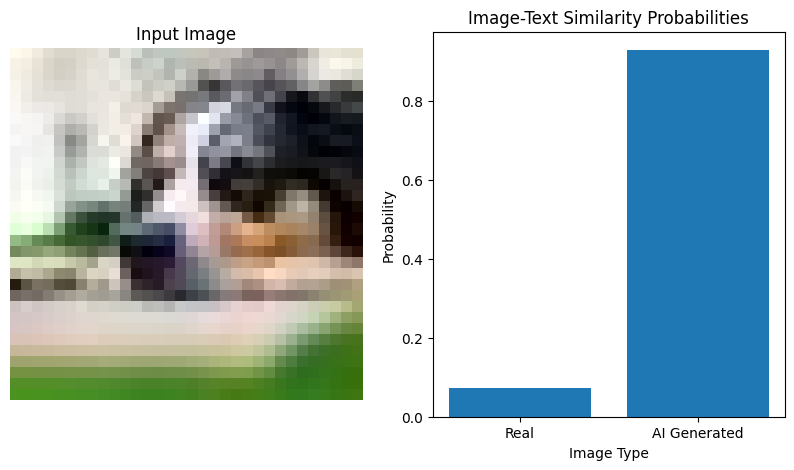

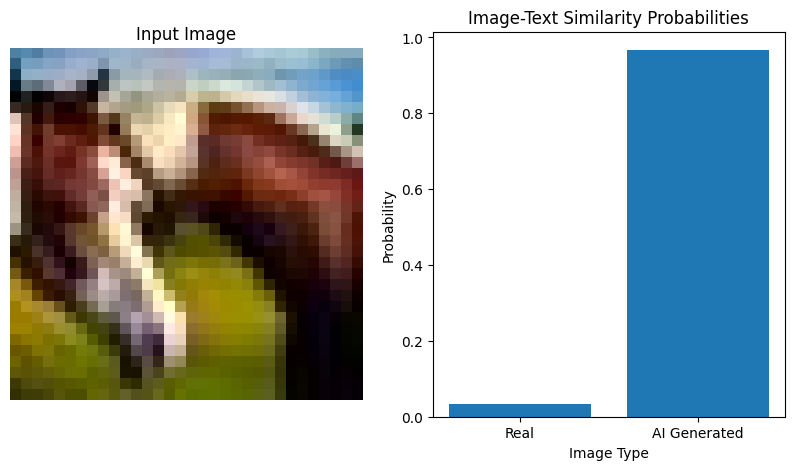

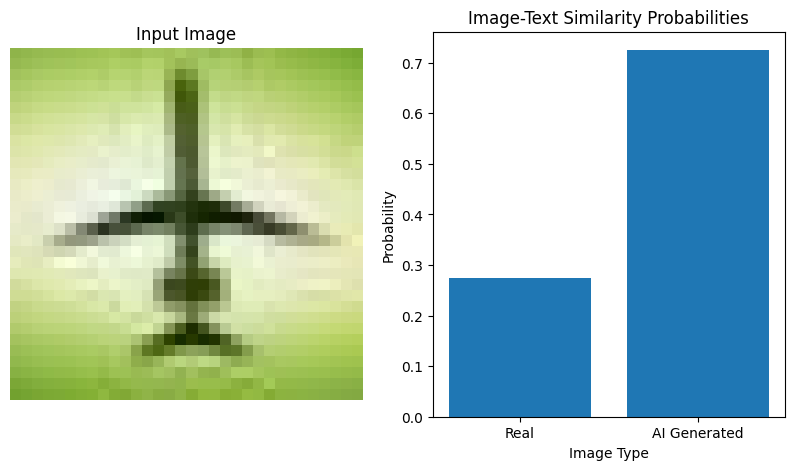

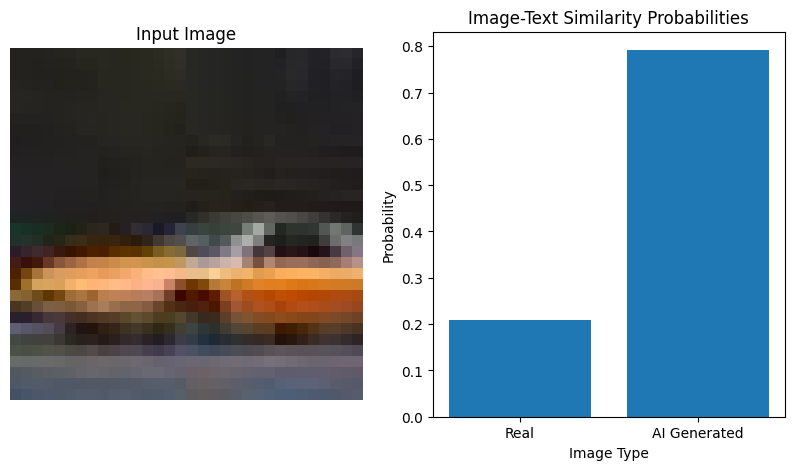

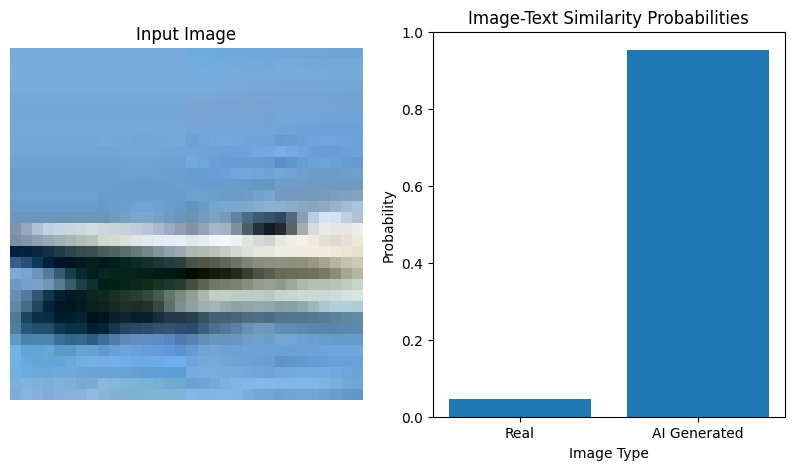

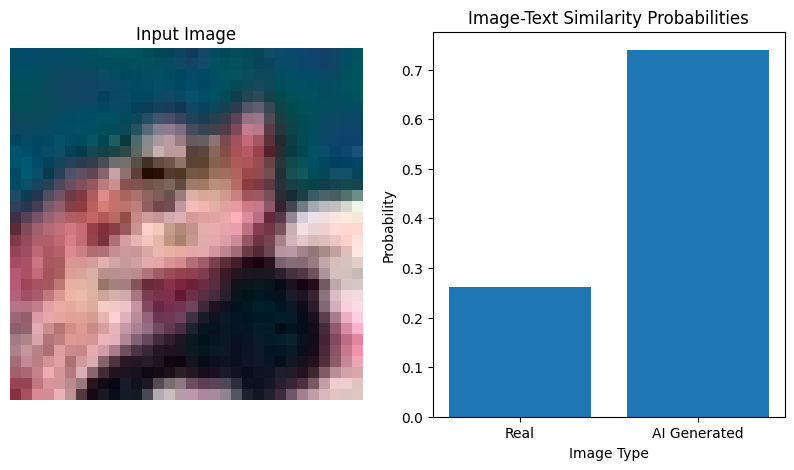

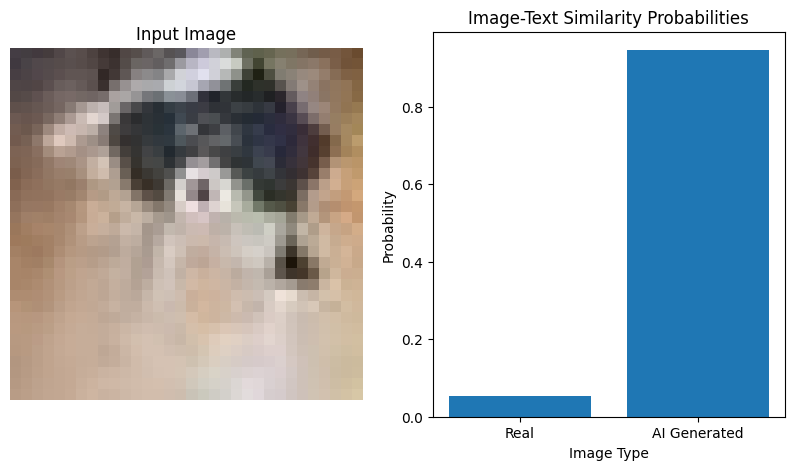

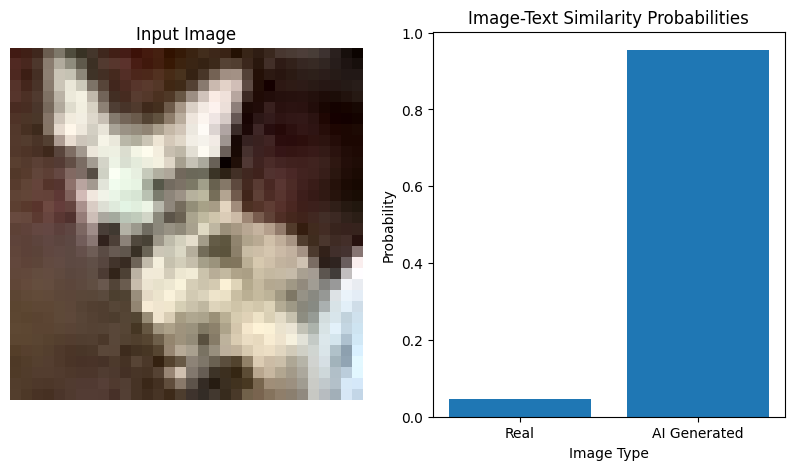

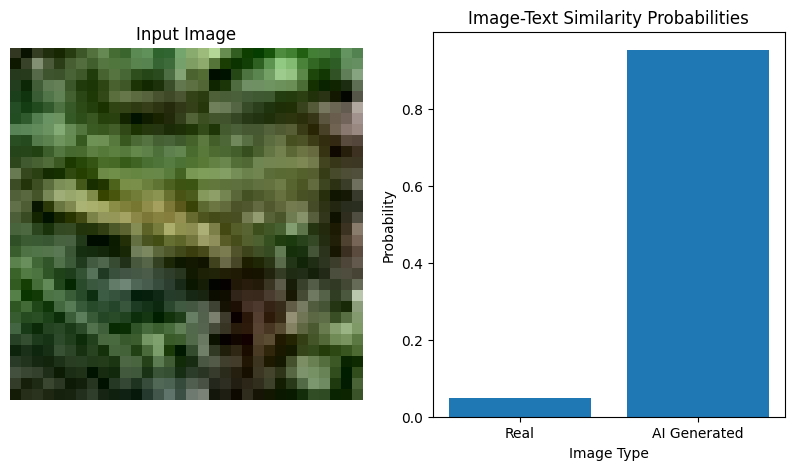

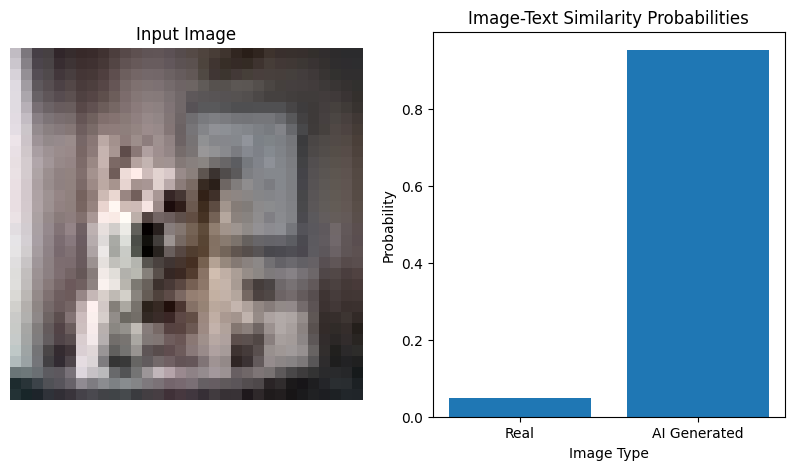

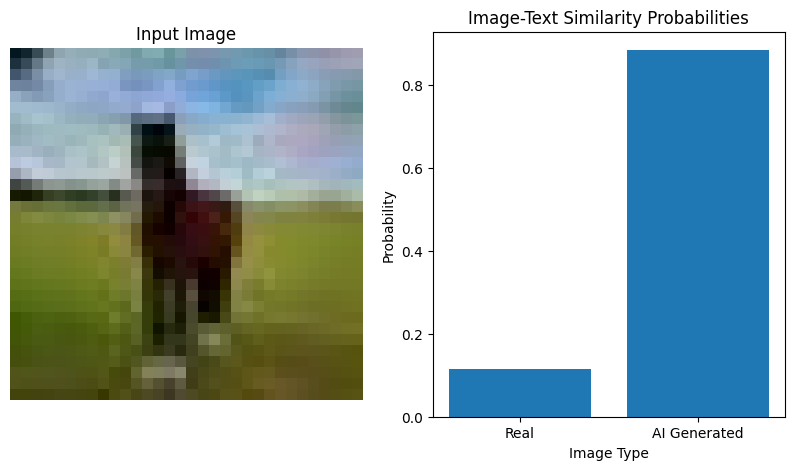

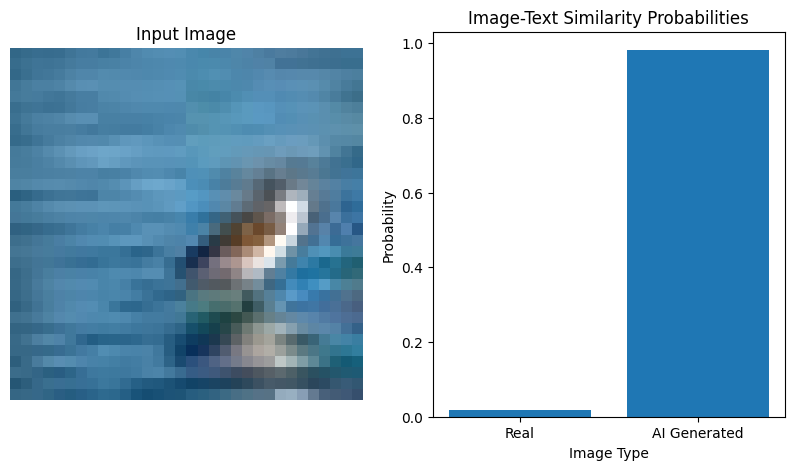

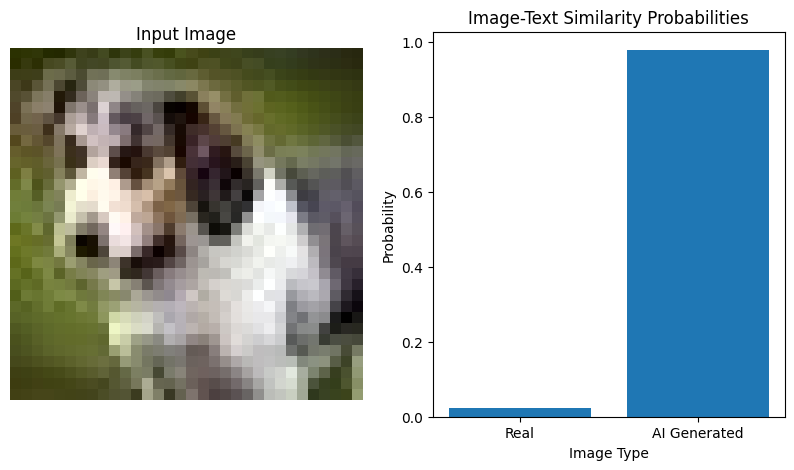

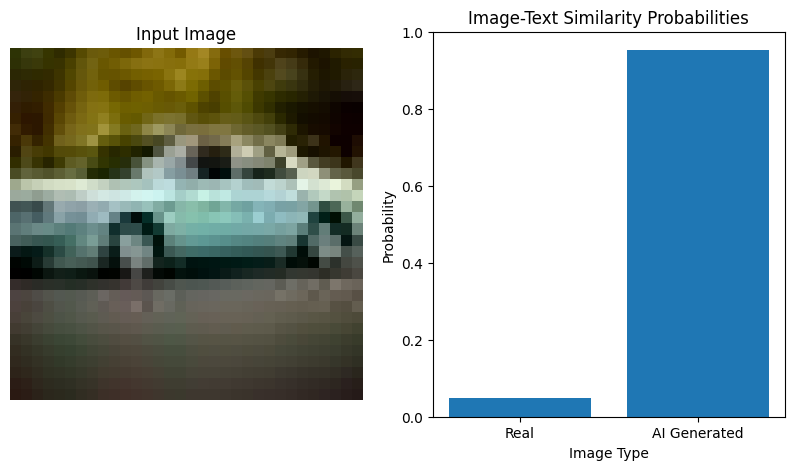

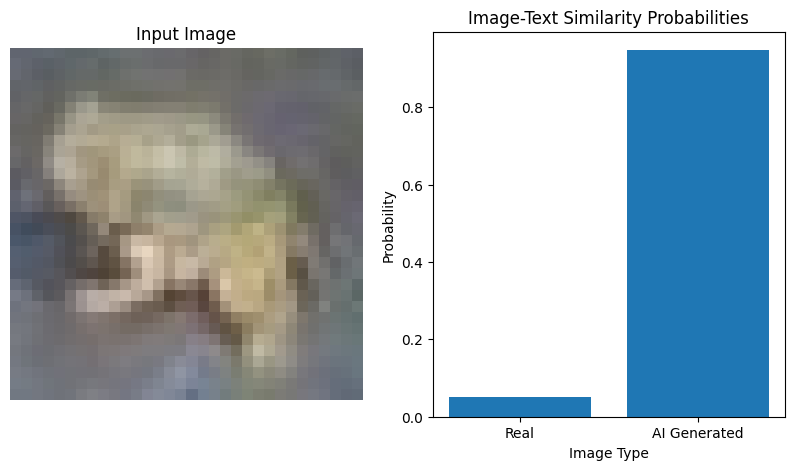

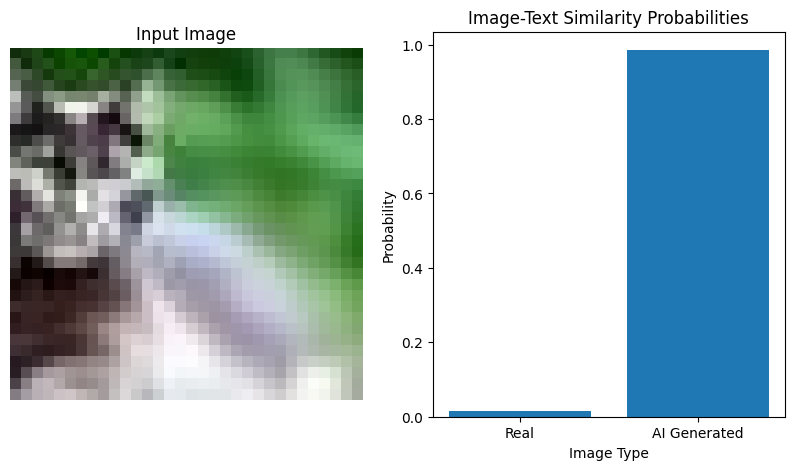

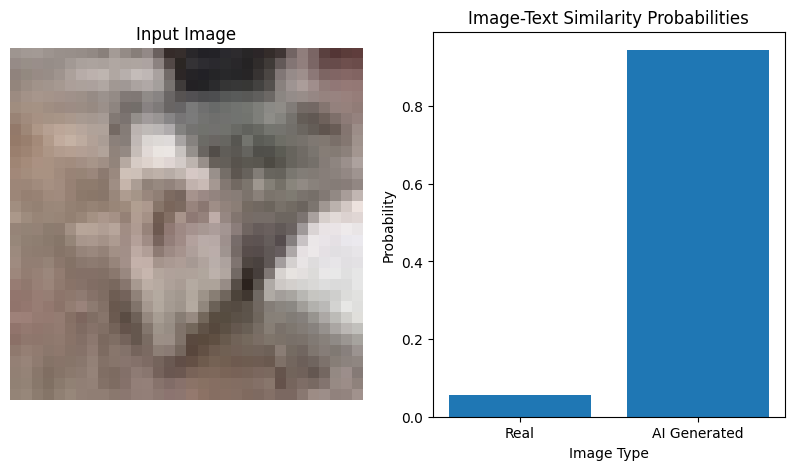

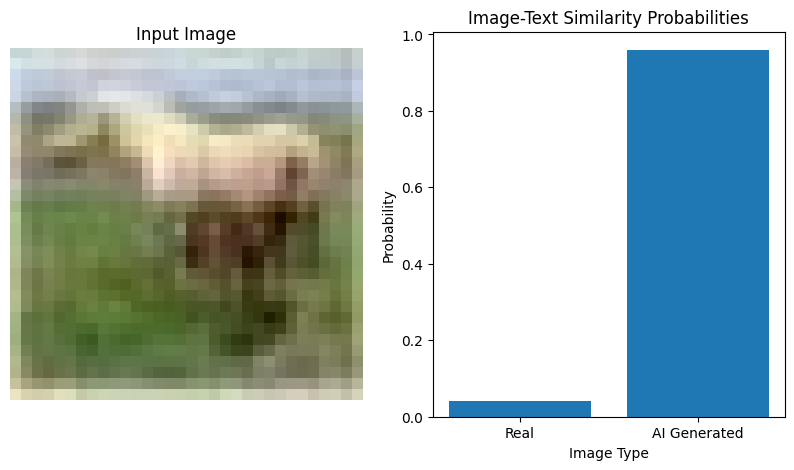

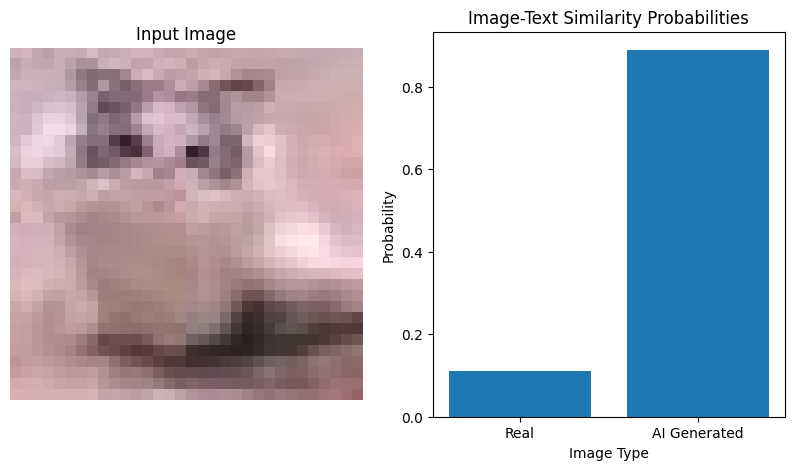

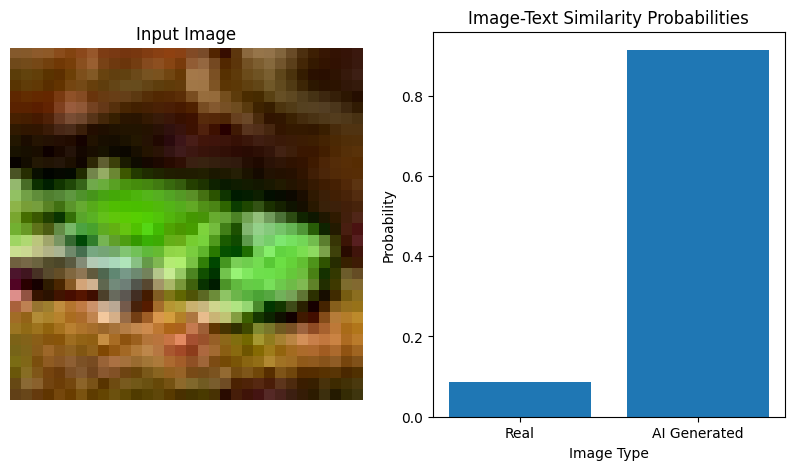

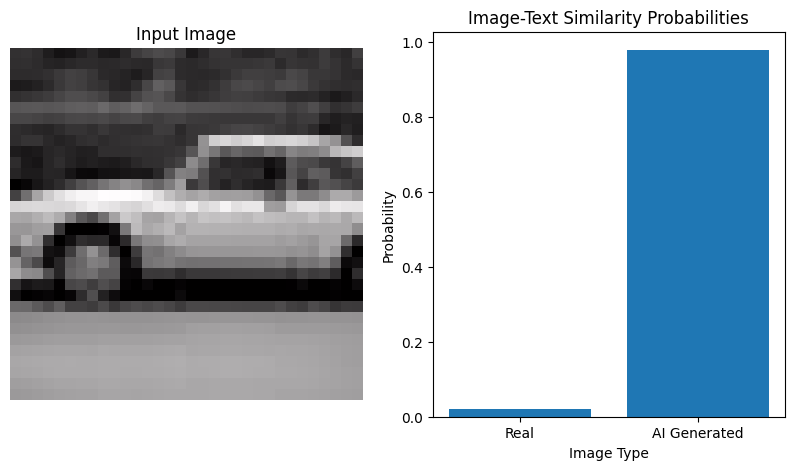

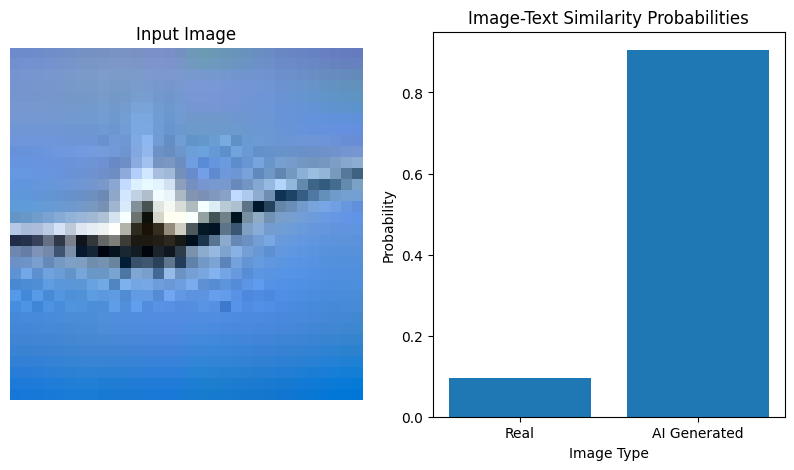

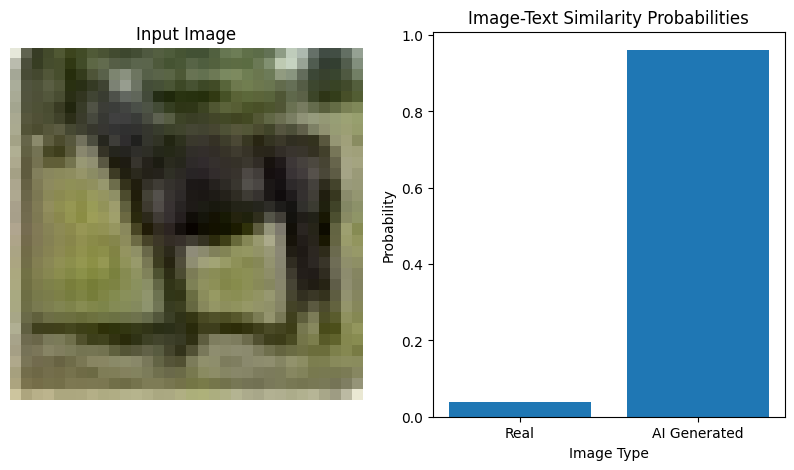

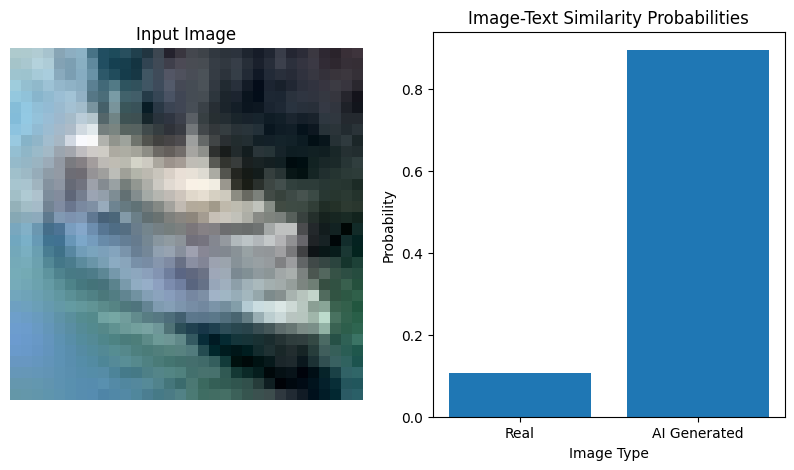

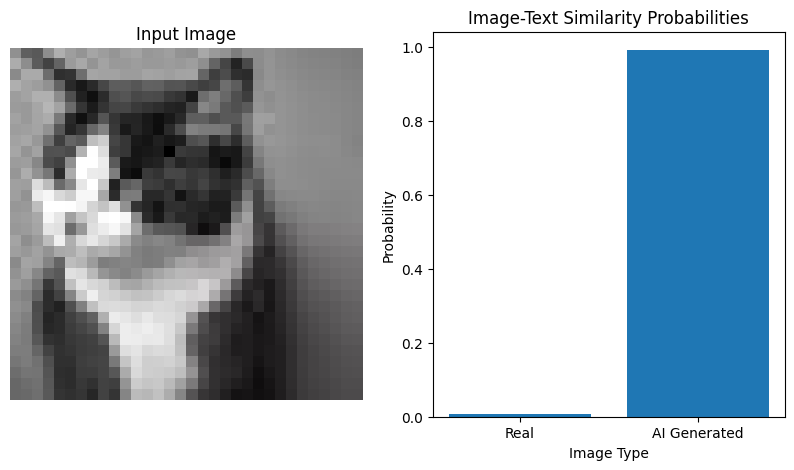

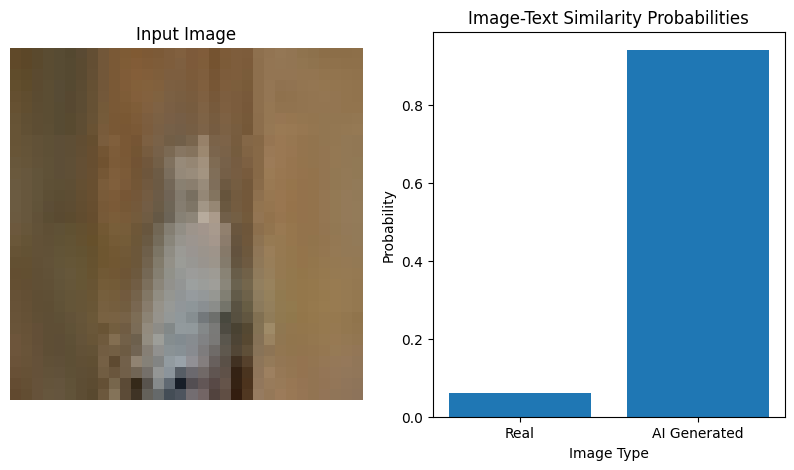

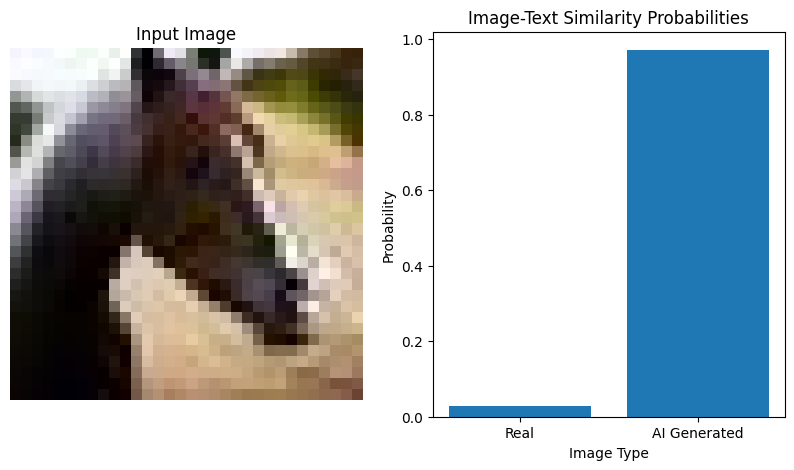

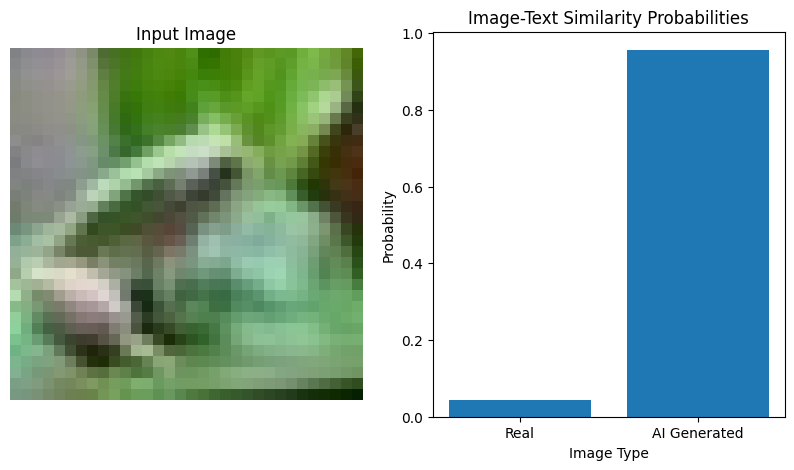

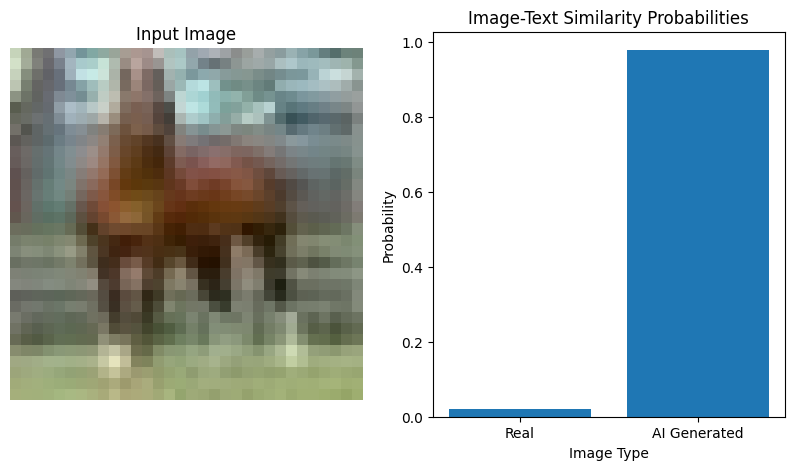

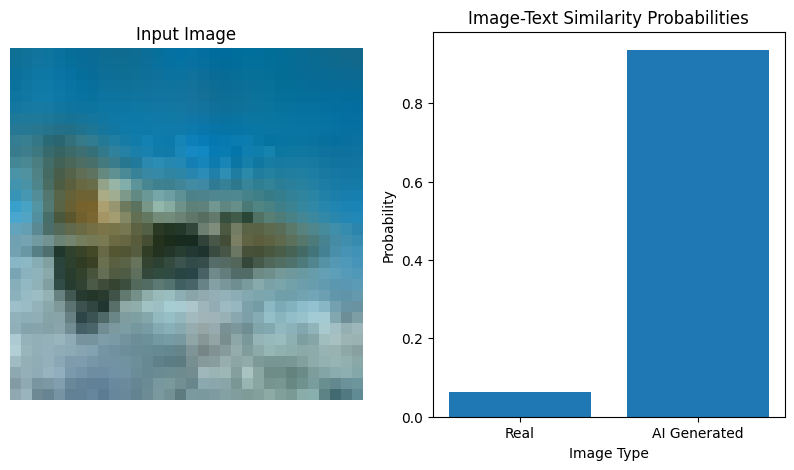

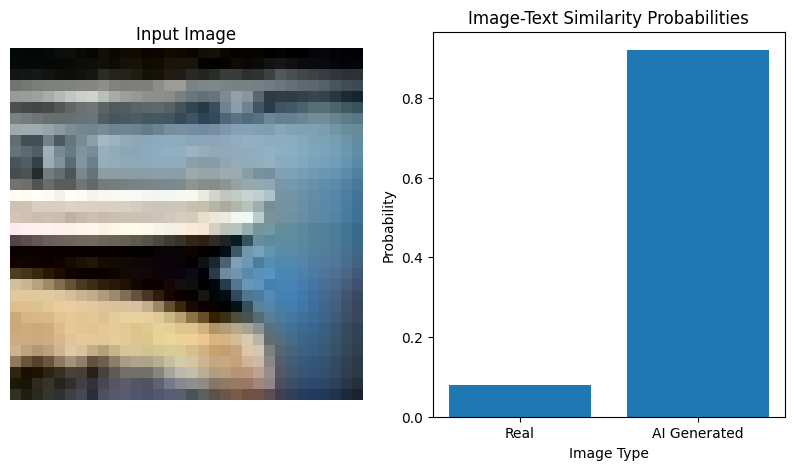

Accuracy: 49.55


In [17]:


clip_processor = AutoProcessor.from_pretrained("openai/clip-vit-base-patch32")
model = AutoModel.from_pretrained("openai/clip-vit-base-patch32")

num_of_correct = 0
total = 0

import random
import matplotlib.pyplot as plt
import numpy as np


for timer in range(0, 2000):
  i = random.randint(0, len(eval_dataset) - 1)

  image, label = eval_dataset.__getitem__(i)

  inputs = clip_processor(text = ['Real Image', 'AI generated image'], images=image, return_tensors="pt", padding = True)
  outputs = model(**inputs)

  logits_per_image = outputs.logits_per_image # this is the image-text similarity score
  probs = logits_per_image.softmax(dim=1) # we can take the softmax to get the label probabilities

  predicted_class = torch.argmax(probs, dim=1)
  correct_prediction = torch.eq(predicted_class, torch.argmax(label, dim = 0))  # Check if prediction matches target

  if random.randint(0, 50) == 0:
    probs_np = probs.detach().cpu().numpy()[0]  # Assuming batch size of 1

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

    # Display the image in the first subplot
    ax1.imshow(image)
    ax1.axis('off')  # Turn off axis ticks and labels
    ax1.set_title('Input Image')

    # Create a bar chart in the second subplot
    ax2.bar(['Real', 'AI Generated'], probs_np)
    ax2.set_title('Image-Text Similarity Probabilities')
    ax2.set_xlabel('Image Type')
    ax2.set_ylabel('Probability')

    plt.show()

  total += 1
  if correct_prediction:
    num_of_correct += 1

print(f'Accuracy: {num_of_correct / total * 100}')
